In [251]:
import numpy as np 
import matplotlib.pyplot as plt 


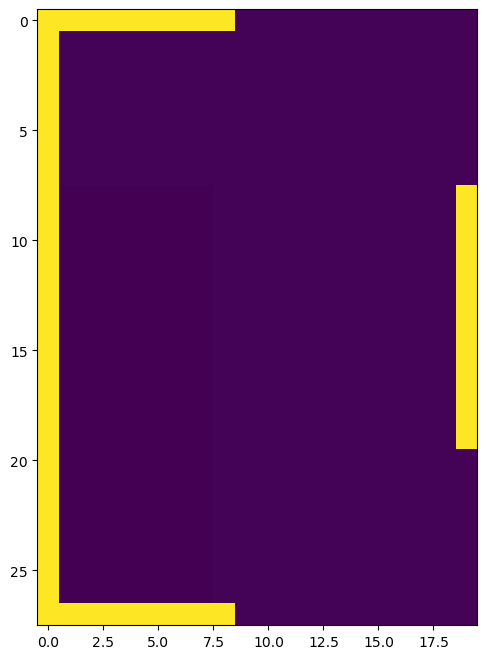

In [254]:
def create_init_temp(h, T_left = 20, T_right = 100):
    '''
    create a grid of intial temperature with regard to boundary conditions
    inputs:     
        - h: step length in x and y direction 
    outputs:
        - T0: inital temperature for grid
    '''
    x_end = 10
    y_end = 14 
    N = int(x_end/h)
    M = int(y_end/h)
    T0 = np.ones((N,M))

    T0[:int(4/h), int(4/h):] = np.zeros_like(T0[:int(4/h), int(4/h):])
    T0[int(10/h):, int(4/h):] = np.zeros_like(T0[int(10/h):, int(4/h):])

    T0[0, :] = T_left
    T0[:int(4/h)+1, 0] = T_left
    T0[:int(4/h)+1, -1] = T_left
    
    T0[-1, int(4/h):(int(10/h))] = T_right
    return T0

T0 = create_init_temp(0.5, 100, 100)
plt.figure(figsize = (8,8))
plt.imshow(T0.T)

In [337]:
def GS_iteration(T0):
    '''
    one iteration with GS on the grid with neumann conditions

    input:
        - T0: Intial temperature 
    output:
        - T: proposed solution
    '''
    T = np.copy(T0)
    N,M = np.shape(T0)
    h = 10/N  
    for i in range(1, N-1): #along x
        for j in range(1, M-1): #along y 
            if(i*h > 4 and (j*h > 10.0-h or j*h < 4.0)): #outside of feasible set
                T[i,j] = 0
                continue
            elif((i)*h == 4.0 and (j*h == 4.0 or j*h == 10.0-h)):
                T[i,j] = 1/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])

            elif((i)*h == 4.0 and (j*h <= 4.0 or j*h >= 10.0-h)): #boundary along x = 4
                T[i,j] = 1/4*(T[i,j+1]+ T[i,j-1] + 2*T[i-1, j])
                continue
            elif((i*h >= 4.0) and (j*h == 4.0)): #boundary along y = 4  
                T[i,j] = 1/4*(2*T[i,j+1] + T[i-1,j] + T[i+1,j] )
                continue
            elif((i*h >= 4.0) and (j*h == 10.0-h)): #boundary along y = 10  
                T[i,j] = 1/4*(T[i+1,j] + T[i-1,j] + 2*T[i,j-1])
                continue
            else:
                T[i,j] = 1/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
                continue
    return T


In [336]:
def gauss_seidel(T0, max_iter = 200):
    '''
    does gaus seidel a finite number of times with neumann conditions
    input: 
        - T0: intial temperature 
        - max_iter: numer of iterations
    output:
        - T: solution proposal 
        - differences: resiudal error (not certain about this yet)
        - index: indicates amount of iterations
    
    '''
    differences = []
    index = []
    i = 0
    T = np.copy(T0)
    T_new = GS_iteration(T) 
    diff_T = np.linalg.norm(T_new -T)
    while(i < max_iter):
        T_new = GS_iteration(T)
        diff_T = np.linalg.norm(T_new - T)
        differences.append(diff_T)
        T = T_new
        i+=1
        index.append(i)
        
    return T, differences, index

In [335]:
def gauss_seidel_2(T0, tol = 0.5**2, max_iter = 200):
    '''
    does gaus seidel a finite number with neumann condtions
    input: 
        - T0: intial temperature 
        - tol: tolerance for residual error
        - max_iter: numer of iterations
    output:
        - T: solution proposal 
        - differences: resiudal error (not certain about this yet)
        - index: indicates amount of iterations
    
    '''
    differences = []
    index = []
    i = 0
    T = np.copy(T0)
    T_new = GS_iteration(T) 
    diff_T = np.linalg.norm(T_new -T)
    while(i < max_iter and diff_T > tol):
        T_new = GS_iteration(T)
        diff_T = np.linalg.norm(T_new - T)
        differences.append(diff_T)
        T = T_new
        i+=1
        index.append(i)
        
    return T, differences, index


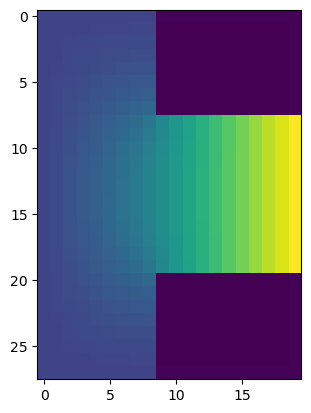

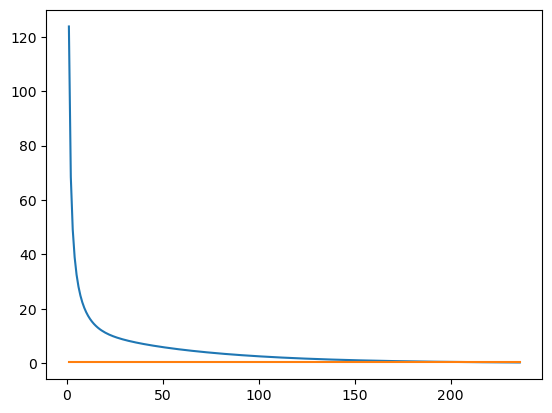

In [308]:
h = 0.5
T0 = create_init_temp(h, 20, 100)
T, differences, index = gauss_seidel_2(T0, tol = h**2, max_iter=1000)
plt.figure()
plt.imshow(T.T)

plt.figure()
plt.plot(index, differences)
plt.plot(index, 0.5**2*np.ones_like(index))

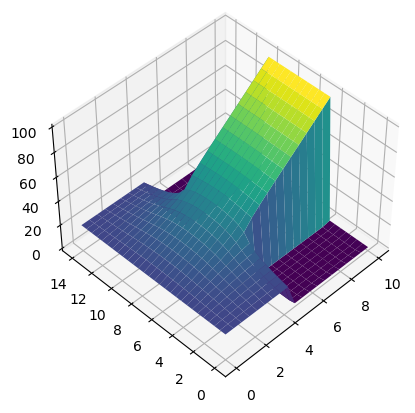

In [309]:
N,M = np.shape(T)
x = np.linspace(0,10, N)
y = np.linspace(0,14, M)
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, T.T, cmap='viridis')
ax.view_init(45, -135)

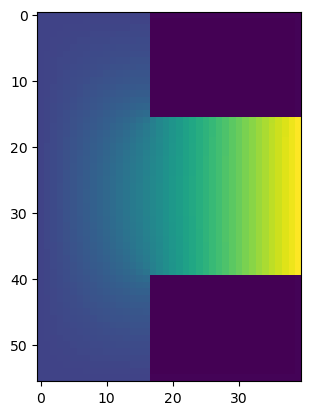

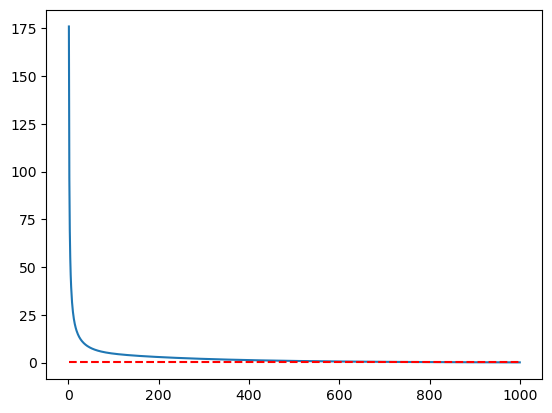

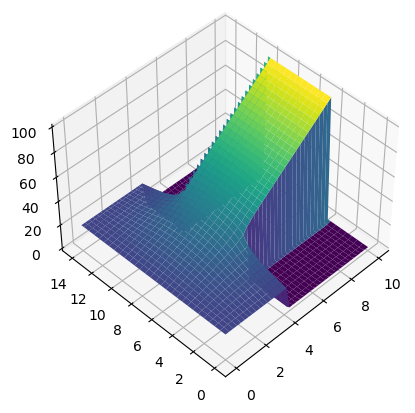

In [310]:
T0 = create_init_temp(0.25)
T, differences, index = gauss_seidel_2(T0, max_iter = 1000, tol = 0.25**2)
plt.figure()
plt.imshow(T.T)
plt.figure()
plt.plot(index, differences)
plt.plot(index, 0.25**2*np.ones_like(index), 'r--')
N,M = np.shape(T)
x = np.linspace(0,10, N)
y = np.linspace(0,14, M)
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, T.T, cmap='viridis')
ax.view_init(45, -135)

In [334]:
def SOR_iteration_neumann(T0, omega):
    '''
    one iteration with GS on the grid with neumann conditions

    input:
        - T0: Intial temperature 
    output:
        - T: proposed solution
    '''
    T = np.copy(T0)
    N,M = np.shape(T0)
    h= 10/N  
    for i in range(1, N-1): #along x
        for j in range(1,M-1): #along y  
            if(i*h > 4 and (j*h > 10.0-h or j*h < 4.0)): #outside of feasible set
                T[i,j] = 0
                continue
            elif(i*h == 4.0 and (j*h == 4.0 or j*h == 10.0-h)):
                T[i,j] = (1-omega)*T[i,j] + omega/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
            elif(i*h == 4.0 and (j*h <= 4.0 or j*h >= 10.0)): #boundary along x = 4
                T[i,j] = (1-omega)*T[i,j] + omega/4*(T[i,j+1]+ T[i,j-1] + 2*T[i-1,j])
                continue
            elif((i*h >= 4.0) and (j*h == 4.0)): #boundary along y = 4  
                T[i,j] = (1-omega)*T[i,j] + omega/4*(2*T[i,j+1] + T[i-1,j] + T[i+1,j] )
                continue
            elif(i*h >= 4.0) and ((j*h == 10.0-h)): #boundary along y = 10  
                T[i,j] = (1-omega)*T[i,j] + omega/4*(T[i+1,j] + T[i-1,j] + 2*T[i,j-1])
                continue
            else:
                T[i,j] = (1-omega)*T[i,j] + omega/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
                continue
    return T

In [333]:
def SOR_neumann(T0, omega, tol = 0.5**2, max_iter = 200):
    '''
    does gaus seidel a finite number of times with neumann conditions
    input: 
        - T0: intial temperature 
        - tol: tolerance for residual error
        - max_iter: numer of iterations
    output:
        - T: solution proposal 
        - differences: resiudal error (not certain about this yet)
        - index: indicates amount of iterations
    
    '''
    differences = []
    index = []
    i = 0
    T = np.copy(T0)
    T_new = GS_iteration(T) 
    diff_T = np.linalg.norm(T_new -T)
    while(i < max_iter and diff_T > tol):
        T_new = SOR_iteration_neumann(T, omega)
        diff_T = np.linalg.norm(T_new - T)
        differences.append(diff_T)
        T = T_new
        i+=1
        index.append(i)
        
    return T, differences, index

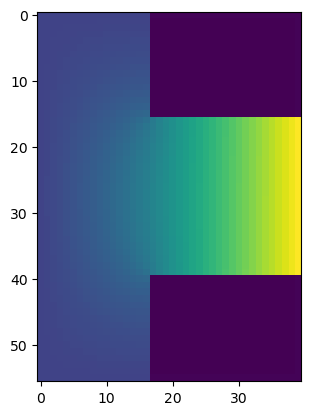

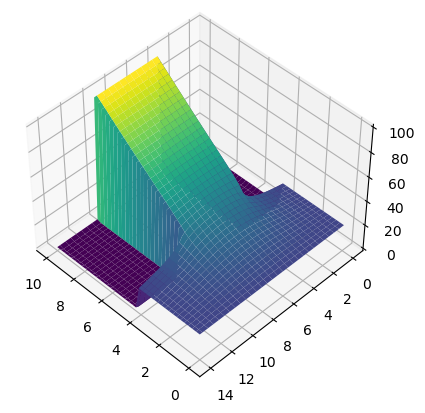

In [312]:
TO = create_init_temp(0.5)
T, differences, index = SOR_neumann(T0, 1.6)
plt.imshow(T.T)

N,M = np.shape(T)
x = np.linspace(0,10, N)
y = np.linspace(0,14, M)
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, T.T, cmap='viridis')
ax.view_init(45, 135)

In [313]:
T0 = create_init_temp(0.5)
omega = np.linspace(0.0, 2, 100, endpoint = False)[1:]
indexes = []
for w in omega:
    T, differences, index = SOR_neumann(T0, w, max_iter=1000)
    indexes.append(index[-1])


In [314]:
print(omega[np.argmin(indexes)])
h = 0.5
T0 = create_init_temp(h)
T, differences, index = SOR_neumann(T0, omega[np.argmin(indexes)], max_iter = 1000)


1.78


41


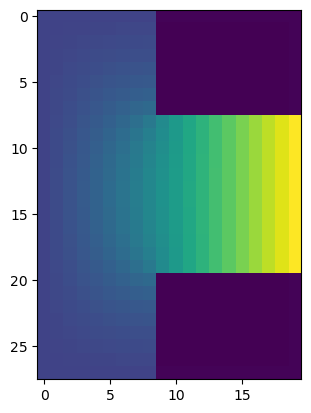

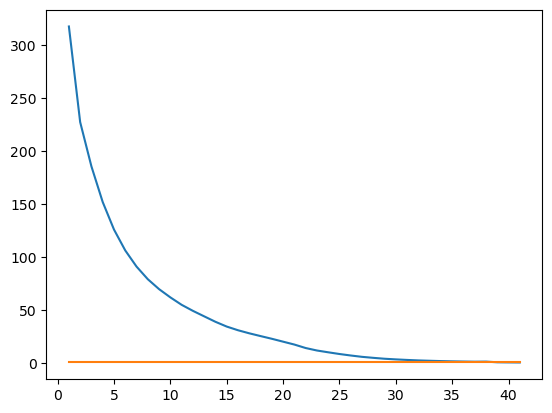

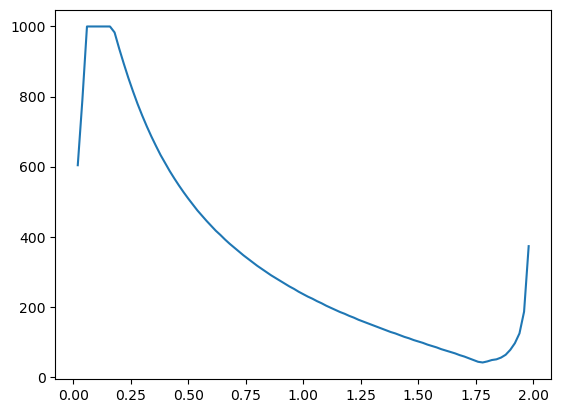

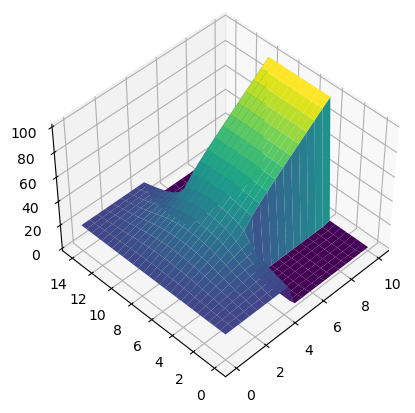

In [315]:
print(index[-1])
plt.imshow(T.T)
plt.figure()
plt.plot(index, differences)
plt.plot(index, h**2 * np.ones_like(differences))
plt.figure()
plt.plot(omega, indexes)
N,M = np.shape(T)
x = np.linspace(0,10, N)
y = np.linspace(0,14, M)
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, T.T, cmap='viridis')
ax.view_init(45, -135)

# Robin conditions

In [332]:
def GS_iteration_robin(T0, gamma = 1):
    '''
    one iteration with GS on the grid with robin conditions

    input:
        - T0: Intial temperature 
    output:
        - T: proposed solution
    '''
    T = np.copy(T0)
    N,M = np.shape(T0)
    h= 10/N  
    for i in range(1, N-1): #along x
        for j in range(1,M-1): #along y  
            if(i*h > 4 and (j*h > 10.0-h or j*h < 4.0)): #outside of feasible set
                T[i,j] = 0
                continue
            elif(i*h == 4.0 and (j*h == 4.0 or j*h == 10.0-h)):
                T[i,j] = 1/(4*(1+h/2*gamma))*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
            
            elif(i*h == 4.0 and (j*h <= 4.0 or j*h >= 10.0)): #boundary along x = 4
                T[i,j] = 1/(4*(1+h/2*gamma))*(T[i,j+1]+ T[i,j-1] + 2*T[i-1,j])
                continue
            
            elif((i*h >= 4.0) and (j*h == 4.0)): #boundary along y = 4  
                T[i,j] = 1/(4*(1+h/2*gamma))*(2*T[i,j+1] + T[i-1,j] + T[i+1,j] )
                continue
            
            elif(i*h >= 4.0) and ((j*h == 10.0-h)): #boundary along y = 10  
                T[i,j] = 1/(4*(1+h/2*gamma))*(T[i+1,j] + T[i-1,j] + 2*T[i,j-1])
                continue
            
            else:
                T[i,j] = 1/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
                continue
    return T

In [330]:
def GS_robin(T0, tol = 0.5**2, max_iter = 200, gamma = 1):
    '''
    does gaus seidel a finite number of times with robin conditions 
    input: 
        - T0: intial temperature 
        - tol: tolerance for residual error
        - max_iter: numer of iterations
    output:
        - T: solution proposal 
        - differences: resiudal error (not certain about this yet)
        - index: indicates amount of iterations
    
    '''
    differences = []
    index = []
    i = 0
    T = np.copy(T0)
    T_new = GS_iteration(T) 
    diff_T = np.linalg.norm(T_new -T)
    while(i < max_iter and diff_T > tol):
        T_new = GS_iteration_robin(T, gamma)
        diff_T = np.linalg.norm(T_new - T)
        differences.append(diff_T)
        T = T_new
        i+=1
        index.append(i)
    return T, differences, index

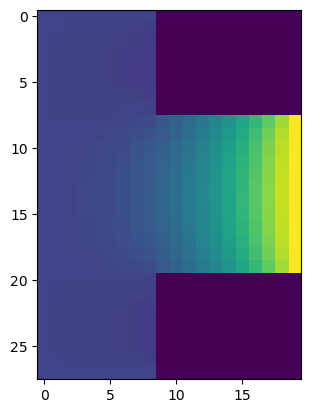

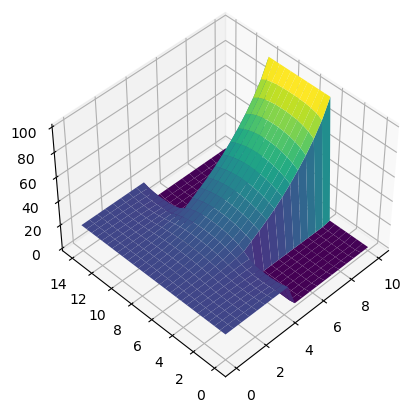

In [349]:
h = 0.5
T0 = create_init_temp(h, T_left = 20, T_right = 100)
T, differences, index = GS_robin(T0, gamma = 0.1, max_iter = 100, tol = h**2)

plt.imshow(T.T)
N,M = np.shape(T)
x = np.linspace(0,10, N)
y = np.linspace(0,14, M)
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, T.T, cmap='viridis')
ax.view_init(45, -135)

In [325]:
def SOR_iteration_robin(T0, omega, gamma = 1):
    '''
    one iteration with GS on the grid with robin conditions
    input:
        - T0: Intial temperature 
    output:
        - T: proposed solution
    '''
    T = np.copy(T0)
    N,M = np.shape(T0)
    h= 10/N  
    for i in range(1, N-1): #along x
        for j in range(1,M-1): #along y  
            if(i*h > 4 and (j*h > 10.0-h or j*h < 4.0)): #outside of feasible set
                T[i,j] = 0
                continue
            elif(i*h == 4.0 and (j*h == 4.0 or j*h == 10.0-h)):
                T[i,j] = (1-omega)*T[i,j] + omega/(4*(1+h/2*gamma))*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
            
            elif(i*h == 4.0 and (j*h <= 4.0 or j*h >= 10.0)): #boundary along x = 4
                T[i,j] = (1-omega)*T[i,j] + omega/(4*(1+h/2*gamma))*(T[i,j+1]+ T[i,j-1] + 2*T[i-1,j])
                continue
            
            elif((i*h >= 4.0) and (j*h == 4.0)): #boundary along y = 4  
                T[i,j] = (1-omega)*T[i,j] + omega/(4*(1+h/2*gamma))*(2*T[i,j+1] + T[i-1,j] + T[i+1,j] )
                continue
            
            elif(i*h >= 4.0) and ((j*h == 10.0-h)): #boundary along y = 10  
                T[i,j] = (1-omega)*T[i,j] + omega/(4*(1+h/2*gamma))*(T[i+1,j] + T[i-1,j] + 2*T[i,j-1])
                continue
            
            else:
                T[i,j] = (1-omega)*T[i,j] + omega/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
                continue
    return T

In [326]:
def SOR_robin(T0, omega, tol = 0.5**2, max_iter = 200, gamma = 1):
    '''
    does gaus seidel a finite number of times 
    for the laplace equation with robin conditions
    input: 
        - T0: intial temperature 
        - tol: tolerance for residual error
        - max_iter: numer of iterations
    output:
        - T: solution proposal 
        - differences: resiudal error (not certain about this yet)
        - index: indicates amount of iterations
    
    '''
    differences = []
    index = []
    i = 0
    T = np.copy(T0)
    T_new = GS_iteration(T) 
    diff_T = np.linalg.norm(T_new -T)
    while(i < max_iter and diff_T > tol):
        T_new = SOR_iteration_robin(T, omega, gamma)
        diff_T = np.linalg.norm(T_new - T)
        differences.append(diff_T)
        T = T_new
        i+=1
        index.append(i)
    return T, differences, index

In [360]:
T0 = create_init_temp(0.5)
omega = np.linspace(0.0, 2, 100, endpoint = False)[1:]
indexes = []
for w in omega:
    T, differences, index = SOR_robin(T0, w, max_iter=1000, gamma = 1)
    indexes.append(index[-1])


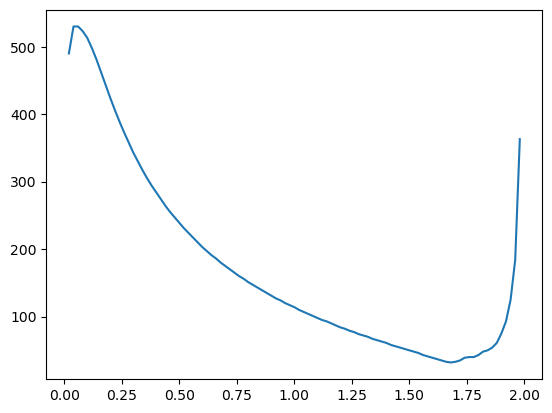

In [361]:

plt.figure()
plt.plot(omega,indexes)

In [370]:
T0 = create_init_temp(0.25)
omega = np.linspace(0.0, 2, 30, endpoint = False)[1:]
indexes = []
for w in omega:
    T, differences, index = SOR_robin(T0, w, max_iter=1000, gamma = 1)
    indexes.append(index[-1])



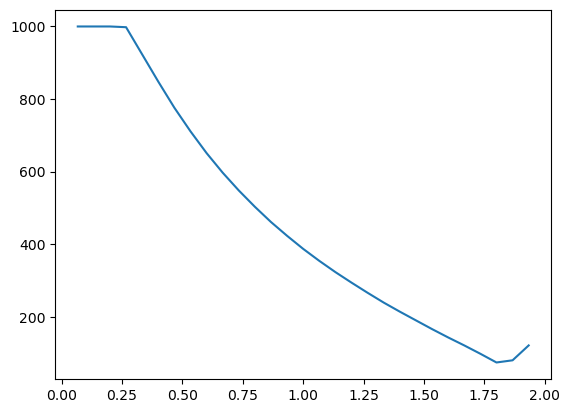

In [371]:
plt.figure()
plt.plot(omega,indexes)

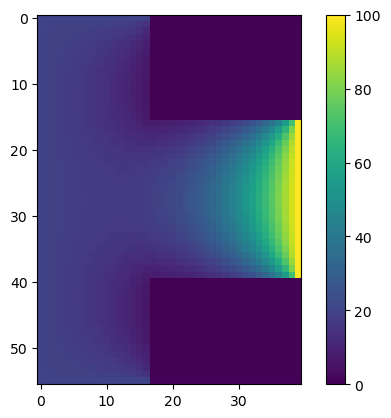

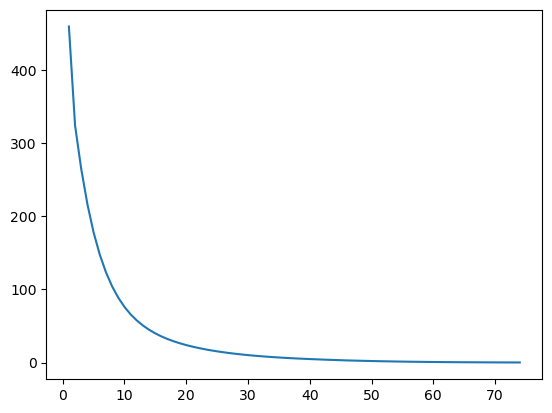

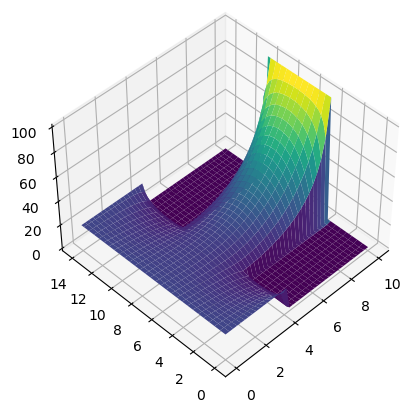

In [372]:
T0 = create_init_temp(0.25, 20, 100)
T,differences, index = SOR_robin(T0, omega[np.argmin(indexes)], max_iter = 1000, gamma = 1)

plt.imshow(T.T)
plt.colorbar()

N,M = np.shape(T)
x = np.linspace(0,10, N)
y = np.linspace(0,14, M)
X,Y = np.meshgrid(x,y)

plt.figure()
plt.plot(index, differences)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



# Plot the surface
ax.plot_surface(X, Y, T.T, cmap='viridis')
ax.view_init(45, -135)